In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
dataset, datasetInfo = tfds.load('malaria', shuffle_files=True, as_supervised=True, with_info=True)

In [ ]:
def preprocess_data(image, label): # Changed function signature
    # Perform any additional preprocessing if needed
    return image, label

# Apply the map function to the training and testing datasets
dataset = dataset['train'].map(preprocess_data)

datasetInfo

In [ ]:
for data in dataset.take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [ ]:
def trainTestSplit(dataset, trainRatio=0, valRatio=0, testRatio=0):

  length = len(dataset)
  trainSet = dataset.take(int(length * trainRatio))
  valSet = dataset.skip(int(length * trainRatio)).take(int(length * valRatio))
  testSet = dataset.skip(int(length * (trainRatio + valRatio))).take(int(length * testRatio))

  return trainSet, valSet, testSet

In [ ]:
trainSet, valSet, testSet = trainTestSplit(dataset, 0.8,0.1,0.1)

In [ ]:
for data in trainSet.take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


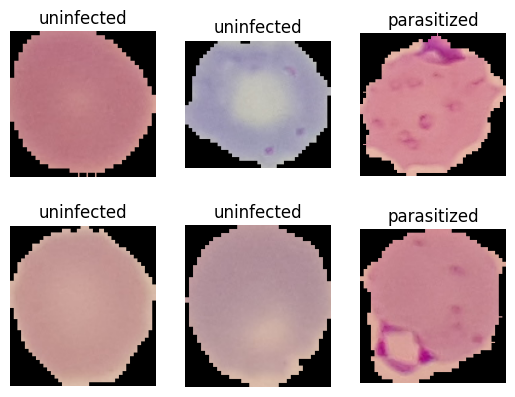

In [ ]:
# data visualization
def imageVisualizer(dataset, n=0):
  for i, (image,label) in enumerate(dataset.take(6)):
    ax = plt.subplot(2,3,i+1)
    plt.imshow(image)
    plt.title(datasetInfo.features['label'].int2str(label))
    plt.axis('off')
  return plt.imshow(image)

imageVisualizer(trainSet, n=6)

In [ ]:
imgSize = 224

def resize_rescale(image, label):
  return tf.image.resize(image, (imgSize, imgSize))/255.0, label

In [ ]:
trainSet = trainSet.map(resize_rescale)
valSet = valSet.map(resize_rescale)
testSet = testSet.map(resize_rescale)

In [ ]:
trainSet

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
trainSet = trainSet.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
valSet = valSet.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
# testSet = testSet.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
trainSet

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
from functools import partial

defaultConv2D = partial(tf.keras.layers.Conv2D, activation='relu', padding='valid')

model= tf.keras.Sequential([
    tf.keras.layers.Input(shape= (imgSize, imgSize, 3)),
    defaultConv2D(filters= 6, kernel_size=3, strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    defaultConv2D(filters= 16, kernel_size=3, strides=1),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    defaultConv2D(filters= 120, kernel_size=3, strides=1),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_5 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_6 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
    )

In [ ]:
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

learningRateScheduler = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=0
)

In [ ]:
history = model.fit(trainSet, validation_data=valSet, epochs=20,callbacks= [earlyStopping, learningRateScheduler] verbose=1)

Epoch 1/20
689/689 [==============================] - 61s 84ms/step - loss: 0.2931 - accuracy: 0.8846 - val_loss: 0.3272 - val_accuracy: 0.8973
Epoch 2/20
689/689 [==============================] - 46s 66ms/step - loss: 0.1805 - accuracy: 0.9350 - val_loss: 0.1741 - val_accuracy: 0.9405
Epoch 3/20
689/689 [==============================] - 46s 66ms/step - loss: 0.1538 - accuracy: 0.9473 - val_loss: 0.1552 - val_accuracy: 0.9434
Epoch 4/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1375 - accuracy: 0.9511 - val_loss: 0.1591 - val_accuracy: 0.9466
Epoch 5/20
689/689 [==============================] - 47s 69ms/step - loss: 0.1343 - accuracy: 0.9518 - val_loss: 0.3079 - val_accuracy: 0.8907
Epoch 6/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1100 - accuracy: 0.9615 - val_loss: 0.1815 - val_accuracy: 0.9459
Epoch 7/20
689/689 [==============================] - 52s 76ms/step - loss: 0.0944 - accuracy: 0.9666 - val_loss: 0.1749 - val_accuracy:

#model evaluation and testing

In [ ]:
testSet = testSet.batch(1)

In [ ]:
model.evaluate(testSet)

2755/2755 [==============================] - 21s 4ms/step - loss: 0.3071 - accuracy: 0.9474


[0.3070595860481262, 0.9473684430122375]

In [ ]:
pORu(model.predict(testSet.take(1))[0][0])

1/1 [==============================] - 18s 18s/step


'u'

In [ ]:
def pORu(x):
  if (x < 0.5):
    return str('p')
  else:
    return str('u')

1/1 [==============================] - 0s 17ms/step


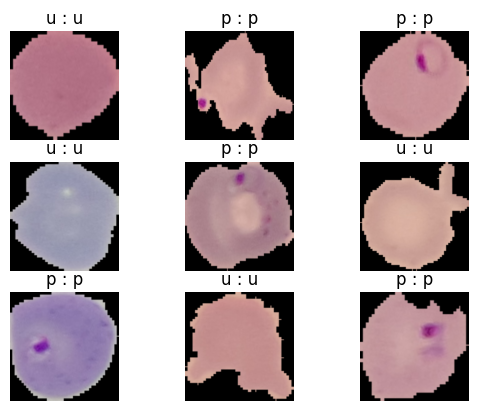

In [ ]:
for i, (image, label) in enumerate(testSet.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(pORu(label.numpy()[0])) + " : " + str(pORu(model.predict(image)[0][0])))
  plt.axis('off')

# Model saving

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/'

# Create a directory for saving the model if it doesn't exist
model_dir = os.path.join(drive_path, 'my_model')
os.makedirs(model_dir, exist_ok=True)


In [ ]:
# Save the entire model in SavedModel format
model.save(os.path.join(model_dir, 'saved_model'))